**Goal**<br>
The goal of this exercise is to generate the information plane studied in class for a multilayer perceptron trained on the MNIST dataset (projected to 12 dimensions using PCA).

*Before you start, make sure to change the runtime type to include a GPU!*

<br>

**Task (adding two lines of code)**<br>
Implement the calculation of the empirical mutual informations $\hat{I} (X;H)$ and $\hat{I} (Y;H)$.

Hint: use the python functions sum and math.log2

<br>

**Submission**<br>
*   Download your code by clicking File -> Download .ipynb
*   Submit your downloaded code on Quercus

In [1]:
import math
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.models as models

from collections import Counter
from sklearn.decomposition import PCA
from torch.utils.data import TensorDataset
from torchvision import datasets, transforms

In [2]:
# hyperparameters
device        = 'cuda'
lr            = 7e-2
epochs        = 10
milestones    = [epochs//2]
gamma         = 0.5
batch_size    = 512
momentum      = 0
weight_decay  = 0
n_bins        = 10

In [3]:
# deep network
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(12, 10)
        self.fc2 = nn.Linear(10, 7)
        self.fc3 = nn.Linear(7, 5)
        self.fc4 = nn.Linear(5, 4)
        self.fc5 = nn.Linear(4, 3)
        self.fc6 = nn.Linear(3, 2)

    def forward(self, x):
        h1 = torch.tanh(self.fc1(x))
        h2 = torch.tanh(self.fc2(h1))
        h3 = torch.tanh(self.fc3(h2))
        h4 = torch.tanh(self.fc4(h3))
        h5 = torch.tanh(self.fc5(h4))
        h6 = F.log_softmax(self.fc6(h5), dim=1)
        return h1, h2, h3, h4, h5, h6

model = Model().to(device)

def process_dataset(dataset):
    # keep only images of two digits
    digit1 = 0
    digit2 = 2

    indices = (dataset.targets == digit1) | (dataset.targets == digit2)
    dataset.data, dataset.targets = dataset.data[indices], dataset.targets[indices]

    dataset.targets[dataset.targets == digit1] = 0
    dataset.targets[dataset.targets == digit2] = 1

    dataset = TensorDataset(dataset.data.reshape(-1, 28*28), dataset.targets)

    return dataset

transform = transforms.ToTensor()
train_dataset = process_dataset(datasets.MNIST('../data', download=True, train=True, transform=transform))
test_dataset = process_dataset(datasets.MNIST('../data', download=True, train=False, transform=transform))

# use PCA to reduce to 12 dimensions
pca = PCA(n_components=12)
pca.fit(train_dataset.tensors[0])
train_dataset.tensors = (torch.from_numpy(pca.transform(train_dataset.tensors[0])).float(), train_dataset.tensors[1])
test_dataset.tensors = (torch.from_numpy(pca.transform(test_dataset.tensors[0])).float(), test_dataset.tensors[1])

# dataset loaders
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

train_loader_full = torch.utils.data.DataLoader(
    train_dataset, batch_size=len(train_loader.dataset), shuffle=False, drop_last=False)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

# loss function
loss_function = nn.NLLLoss()

# optimizer
optimizer = optim.SGD(model.parameters(),
                      lr=lr,
                      momentum=momentum,
                      weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)

Train		Epoch: 1 	Batch 1/23 (4%) 	Batch Loss: 0.690048 	Batch Accuracy: 49.023438
Train		Epoch: 1 	Batch 2/23 (9%) 	Batch Loss: 0.689455 	Batch Accuracy: 48.535156
Train		Epoch: 1 	Batch 3/23 (13%) 	Batch Loss: 0.686317 	Batch Accuracy: 50.130208
Train		Epoch: 1 	Batch 4/23 (17%) 	Batch Loss: 0.689560 	Batch Accuracy: 49.462891
Train		Epoch: 1 	Batch 5/23 (22%) 	Batch Loss: 0.686681 	Batch Accuracy: 49.882812
Train		Epoch: 1 	Batch 6/23 (26%) 	Batch Loss: 0.687884 	Batch Accuracy: 49.641927
Train		Epoch: 1 	Batch 7/23 (30%) 	Batch Loss: 0.685833 	Batch Accuracy: 49.609375
Train		Epoch: 1 	Batch 8/23 (35%) 	Batch Loss: 0.685141 	Batch Accuracy: 49.707031
Train		Epoch: 1 	Batch 9/23 (39%) 	Batch Loss: 0.683015 	Batch Accuracy: 49.913194
Train		Epoch: 1 	Batch 10/23 (43%) 	Batch Loss: 0.684548 	Batch Accuracy: 49.941406
Train		Epoch: 1 	Batch 11/23 (48%) 	Batch Loss: 0.689076 	Batch Accuracy: 49.360795
Train		Epoch: 1 	Batch 12/23 (52%) 	Batch Loss: 0.682603 	Batch Accuracy: 49.902344
Tra

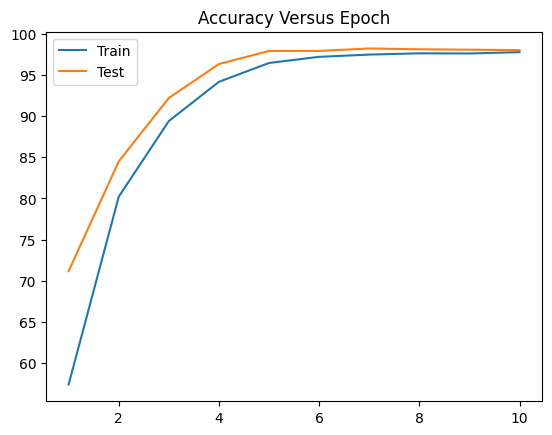

<Figure size 640x480 with 0 Axes>

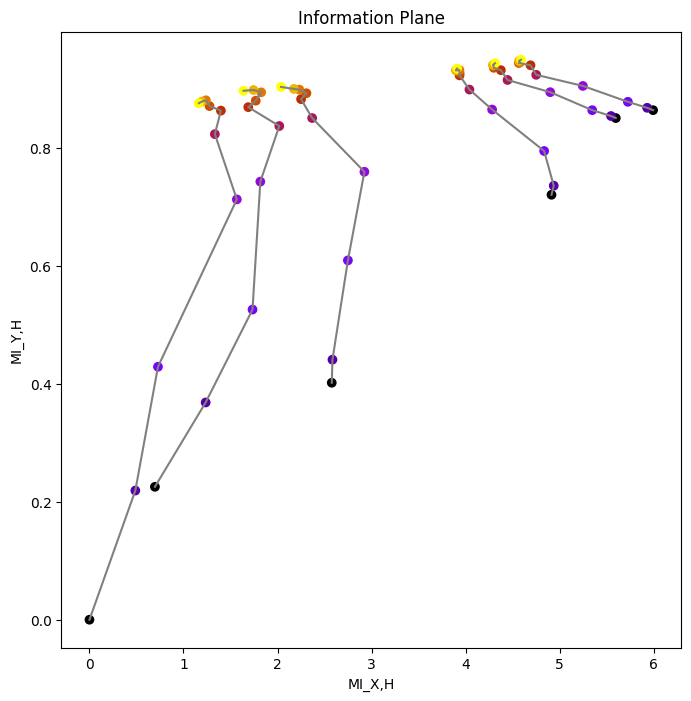

In [4]:
train_accuracy = []
test_accuracy = []

# mutual informations for every epoch and every layer
layers = len(list(model.children()))
MI_XH = torch.zeros(epochs, layers)
MI_YH = torch.zeros(epochs, layers)

# iterate over epochs
for epoch in range(epochs):
    # run model on full train dataset
    for images, labels in train_loader_full:
        images, labels = images.to(device), labels.to(device)

    h_list = model(images)

    # calculate mutual information
    for layer, h in enumerate(h_list):
        # discretize images and representations
        bins = np.linspace(0, 1, n_bins+1)
        x_ = np.digitize(images.cpu(), bins)
        if layer == layers-1:
            h = torch.exp(h)
            bins = np.linspace(0, 1, n_bins+1)
        else:
            bins = np.linspace(-1, 1, n_bins+1)
        h_ = np.digitize(h.cpu().detach().numpy(), bins)
        y_ = labels.cpu()

        # calculate discrete probabilities
        p_X = Counter()
        p_Y = Counter()
        p_H = Counter()
        p_XH = Counter()
        p_YH = Counter()

        for x_i, h_i, y_i in zip(x_, h_, y_):
            def totuple(a):
                try:
                    return tuple(totuple(i) for i in a)
                except:
                    return a.item()

            unit = 1./len(images)

            p_X[totuple(x_i)]                   += unit
            p_Y[totuple(y_i)]                   += unit
            p_H[totuple(h_i)]                   += unit
            p_XH[(totuple(x_i), totuple(h_i))]  += unit
            p_YH[(totuple(y_i), totuple(h_i))]  += unit

        # ADD CODE HERE
        MI_XH[epoch, layer] = sum([p_XH[x, h]*(math.log2(p_XH[x, h]) - math.log2(p_X[x]) - math.log2(p_H[h])) for x, h in p_XH])
        MI_YH[epoch, layer] = sum([p_YH[y, h]*(math.log2(p_YH[y, h]) - math.log2(p_Y[y]) - math.log2(p_H[h])) for y, h in p_YH])

    # train phase
    model.train()
    accuracy = 0
    N = 0

    # iterate over train data
    for batch_idx, (images, labels) in enumerate(train_loader, start=1):
        images, labels = images.to(device), labels.to(device)

        # forward pass
        h1, h2, h3, h4, h5, h6 = model(images)
        loss = loss_function(h6, labels)

        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # check if predicted labels are equal to true labels
        predicted_labels = torch.argmax(h6,dim=1)
        accuracy += torch.sum((predicted_labels==labels).float()).item()
        N += images.shape[0]

        print('Train\t\tEpoch: {} \t'
              'Batch {}/{} ({:.0f}%) \t'
              'Batch Loss: {:.6f} \t'
              'Batch Accuracy: {:.6f}'.format(
                  epoch+1,
                  batch_idx,
                  len(train_loader),
                  100. * batch_idx / len(train_loader),
                  loss.item(),
                  100. * accuracy/N))

    train_accuracy.append(100. * accuracy/N)

    scheduler.step()

    # test phase
    model.eval()
    accuracy = 0
    N = 0

    # iterate over test data
    for batch_idx, (images, labels) in enumerate(test_loader, start=1):
        images, labels = images.to(device), labels.to(device)

        # forward pass
        h1, h2, h3, h4, h5, h6 = model(images)

        # check if predicted labels are equal to true labels
        predicted_labels = torch.argmax(h6,dim=1)
        accuracy += torch.sum((predicted_labels==labels).float()).item()
        N += images.shape[0]
    test_accuracy.append(100. * accuracy/N)
    print(test_accuracy[-1])

# plot results
plt.figure()
plt.title('Accuracy Versus Epoch')
plt.plot(range(1, epochs+1), train_accuracy, label='Train')
plt.plot(range(1, epochs+1), test_accuracy, label='Test')
plt.legend()

plt.figure()
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xlabel('MI_X,H')
ax.set_ylabel('MI_Y,H')
title = ax.set_title('Information Plane')
cmap = plt.get_cmap('gnuplot', epochs)
colors = [cmap(i) for i in np.linspace(0, 1, epochs)]
ax.plot(MI_XH, MI_YH, '-', color='gray')
for layer in range(layers):
    im = ax.scatter(MI_XH[:,layer], MI_YH[:,layer], c=colors)